# San Francisco Airbnb Price Prediction
The goal of this prediction is to help people who are new and possibly old to Airbnb help accurately price their housing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score 
from sklearn.preprocessing import StandardScaler

## What the Data Looks Like

In [2]:
sf = pd.read_csv('../Data/AB_SF_2020.csv')
sf = sf.drop(columns=['id', 'host_id', 'host_name'])
sf = sf.drop(columns=['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude'])
sf = sf.drop(columns=['number_of_reviews', 'last_review', 'reviews_per_month'])
sf

,name,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,"Bright, Modern Garden Unit - 1BR/1B",Entire home/apt,170,1,1,106
1,Creative Sanctuary,Entire home/apt,235,30,1,0
2,A Friendly Room - UCSF/USF - San Francisco,Private room,65,32,9,365
3,Friendly Room Apt. Style -UCSF/USF - San Franc...,Private room,65,32,9,365
4,Historic Alamo Square Victorian,Entire home/apt,703,5,2,365
...,...,...,...,...,...,...
8133,San Francisco Home in the Heart of Lower Haight,Entire home/apt,112,30,1,173
8134,UP to 10 First Responders WANTED for 3 LEVELS ...,Entire home/apt,269,30,4,90
8135,Furnished 3 bedroom house,Entire home/apt,375,30,2,310
8136,Beautiful Room Near Ghirardelli Square for Sublet,Private room,86,30,1,84


## Creating Classes

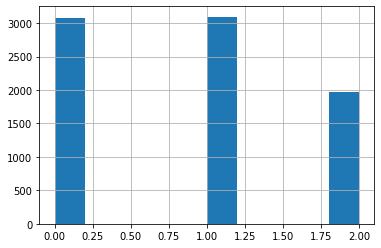

In [3]:
def price_class(val):
    """Determins what class a listing should be given"""
    if val <= 120:
        return 0
    elif val > 120 and val <= 240:
        return 1
    elif val > 240:
        return 2


sf['price'] = sf['price'].apply(lambda x: price_class(x))
sf[sf['price']<360]['price'].hist()

## Data Preprocessing/Feature Extraction

### Name Length

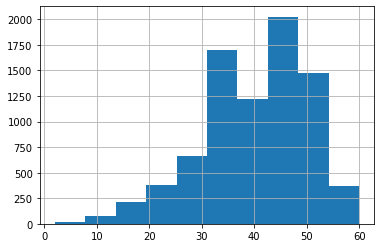

In [4]:
sf['name_length'] = sf['name'].map(str).apply(len)
sf['name_length'] = sf['name_length'].apply(lambda x: 60 if x > 60 else x)
sf = sf.drop(columns=['name'])

sf['name_length'].hist()

### Room Type

In [5]:
# room_to_num = {room:index for index, room in enumerate(sf['room_type'].unique())}
# sf['room_type'] = sf['room_type'].apply(lambda x: room_to_num[x])
# sf['room_type'].hist()

(array([2906.,    0.,    0.,    0.,    0., 4882.,    0.,    0.,    0.,
         263.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

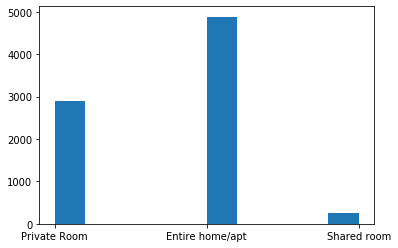

In [6]:
sf['rm_private'] = sf['room_type'].apply(lambda x: 0 if x != 'Private room' else 1)
sf['rm_entire'] = sf['room_type'].apply(lambda x: 0 if x != 'Entire home/apt' else 1)
sf['rm_shared'] = sf['room_type'].apply(lambda x: 0 if x != 'Shared room' else 1)
sf = sf.drop(columns=['room_type'])

sums = [sf['rm_private'].sum(), sf['rm_entire'].sum(), sf['rm_shared'].sum()]
plt.hist(x=['Private Room', 'Entire home/apt', 'Shared room'], weights=sums)

### Minimum Nights

Min Value 1
Max Value 100000000


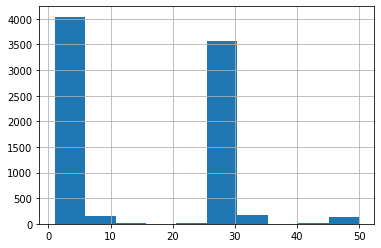

In [7]:
print('Min Value', sf['minimum_nights'].min())
print('Max Value', sf["minimum_nights"].max())

sf['minimum_nights'] = sf['minimum_nights'].apply(lambda x: 50 if x > 50 else x)
sf['minimum_nights'].hist()

### Calculated Host Listings Count

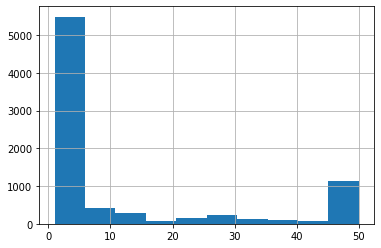

In [8]:
sf['calculated_host_listings_count'] = sf['calculated_host_listings_count'].apply(lambda x: 50 if x > 50 else x)
sf['calculated_host_listings_count'].hist()

### Availability 365

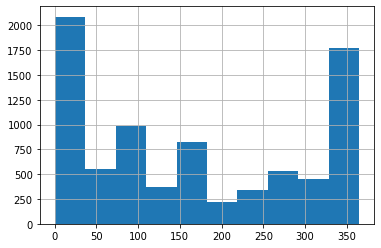

In [9]:
sf['availability_365'].hist()

## Feature Selection

### Feature Correlation

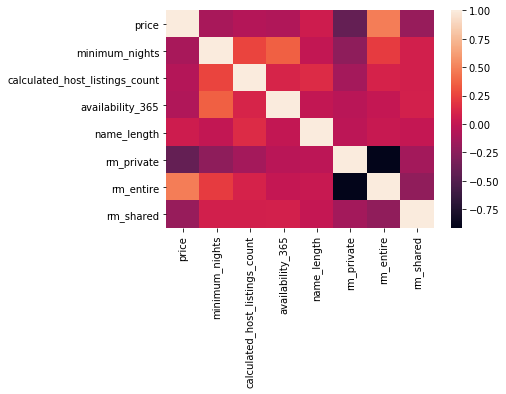

In [10]:
sns.heatmap(sf.corr())

### Feature Importance

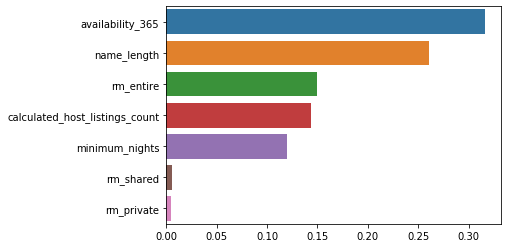

In [11]:
tree_reg = DecisionTreeClassifier()
tree_reg.fit(sf.drop(columns=['price']), sf['price'])

feature_imp = pd.Series(tree_reg.feature_importances_,index=sf.drop(columns=['price']).columns).sort_values(ascending=False)
%matplotlib inline
sns.barplot(x=feature_imp, y=feature_imp.index)

### Selecting Features and Splitting Data

In [12]:
sf = sf.drop(columns=['rm_shared', 'rm_private'])

X, y = sf.drop(columns=['price']), sf['price']

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

X_r_train, X_r_test, y_train, y_test = train_test_split(X_r, y, test_size=0.20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

## Model Selection

### Decision Tree Classifier

In [13]:
# Without PCA
tree_class = DecisionTreeClassifier(max_depth=5)
tree_class.fit(X_train, y_train)

tree_pred = tree_class.predict(X_test)
tree_f1_score = f1_score(y_test, tree_pred, average='micro')
tree_all_f1 = cross_val_score(estimator=tree_class, X=tree_pred.reshape(-1, 1), y=y_test, cv=5)
tree_accuracy = accuracy_score(y_test, tree_pred)
tree_all_accuracy = cross_val_score(estimator=tree_class, X=tree_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(tree_class.score(X_train, y_train))
print('F1 Score', tree_f1_score)
print('Mean F1 Score', tree_all_f1.mean())
print('Accuracy', tree_accuracy)
print('Mean Accuracy', tree_all_accuracy.mean())

0.6204301075268818
F1 Score 0.6124078624078624
Mean F1 Score 0.6124266163284569
Accuracy 0.6124078624078624
Mean Accuracy 0.6124266163284569


In [14]:
# With PCA
tree_r_class = DecisionTreeClassifier(max_depth=2)
tree_r_class.fit(X_r_train, y_train)

tree_r_pred = tree_r_class.predict(X_r_test)
tree_r_f1_score = f1_score(y_test, tree_r_pred, average='micro')
tree_r_all_f1 = cross_val_score(estimator=tree_r_class, X=tree_r_pred.reshape(-1, 1), y=y_test, cv=5)
tree_r_accuracy = accuracy_score(y_test, tree_r_pred)
tree_r_all_accuracy = cross_val_score(estimator=tree_r_class, X=tree_r_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(tree_r_class.score(X_r_train, y_train))
print('F1 Score', tree_r_f1_score)
print('Mean F1 Score', tree_r_all_f1.mean())
print('Accuracy', tree_r_accuracy)
print('Mean Accuracy', tree_r_all_accuracy.mean())

0.4302611367127496
F1 Score 0.4201474201474201
Mean F1 Score 0.42015667767815
Accuracy 0.4201474201474201
Mean Accuracy 0.42015667767815


### Logistic Regressor

In [15]:
# Without PCA
log_class = LogisticRegression(solver='sag', multi_class='auto', max_iter=8000)
log_class.fit(X_train, y_train)

log_pred = log_class.predict(X_test)
log_f1 = f1_score(y_test, log_pred, average='micro')
log_all_f1 = cross_val_score(estimator=log_class, X=log_pred.reshape(-1, 1), y=y_test, cv=5)
log_accuracy = accuracy_score(y_test, tree_pred)
log_all_accuracy = cross_val_score(estimator=log_class, X=log_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(log_class.score(X_train, y_train))
print('F1 Score', log_f1)
print('Mean F1 Score', log_all_f1.mean())
print('Accuracy', log_accuracy)
print('Mean Accuracy', log_all_accuracy.mean())

0.581874039938556
F1 Score 0.5804668304668305
Mean F1 Score 0.5804832468145351
Accuracy 0.6124078624078624
Mean Accuracy 0.5804832468145351


In [16]:
# With PCA
log_r_class = LogisticRegression(solver='sag', multi_class='auto', max_iter=8000)
log_r_class.fit(X_r_train, y_train)

log_r_pred = log_r_class.predict(X_r_test)
log_r_f1_score = f1_score(y_test, log_r_pred, average='micro')
log_r_all_f1 = cross_val_score(estimator=log_r_class, X=log_r_pred.reshape(-1, 1), y=y_test, cv=5)
log_r_accuracy = accuracy_score(y_test, tree_r_pred)
log_r_all_accuracy = cross_val_score(estimator=log_r_class, X=log_r_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(tree_r_class.score(X_r_train, y_train))
print('F1 Score', tree_r_f1_score)
print('Mean F1 Score', tree_r_all_f1.mean())
print('Accuracy', tree_r_accuracy)
print('Mean Accuracy', tree_r_all_accuracy.mean())

0.4302611367127496
F1 Score 0.4201474201474201
Mean F1 Score 0.42015667767815
Accuracy 0.4201474201474201
Mean Accuracy 0.42015667767815


### Suport Vector Classifier

In [17]:
# Without PCA
sv_class = SVC(gamma='auto')
sv_class.fit(X_train, y_train)

sv_pred = sv_class.predict(X_test)
sv_f1 = f1_score(y_test, sv_pred, average='micro')
sv_all_f1 = cross_val_score(estimator=sv_class, X=sv_pred.reshape(-1, 1), y=y_test, cv=5)
sv_accuracy = accuracy_score(y_test, sv_pred)
sv_all_accuracy = cross_val_score(estimator=sv_class, X=sv_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(sv_class.score(X_train, y_train))
print('F1 Score', sv_f1)
print('Mean F1 Score', sv_all_f1.mean())
print('Accuracy', sv_accuracy)
print('Mean Accuracy', sv_all_accuracy.mean())

0.6129032258064516
F1 Score 0.605036855036855
Mean F1 Score 0.6050438886267107
Accuracy 0.605036855036855
Mean Accuracy 0.6050438886267107


In [18]:
# With PCA
sv_r_class = SVC(gamma='auto')
sv_r_class.fit(X_r_train, y_train)

sv_r_pred = sv_r_class.predict(X_r_test)
sv_r_f1 = f1_score(y_test, sv_r_pred, average='micro')
sv_r_all_f1 = cross_val_score(estimator=sv_r_class, X=sv_r_pred.reshape(-1, 1), y=y_test, cv=5)
sv_r_accuracy = accuracy_score(y_test, sv_r_pred)
sv_r_all_accuracy = cross_val_score(estimator=sv_r_class, X=sv_r_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(sv_r_class.score(X_r_train, y_train))
print('F1 Score', sv_r_f1)
print('Mean F1 Score', sv_r_all_f1.mean())
print('Accuracy', sv_r_accuracy)
print('Mean Accuracy', sv_r_all_accuracy.mean())

0.46897081413210445
F1 Score 0.4477886977886978
Mean F1 Score 0.44286550259556395
Accuracy 0.4477886977886978
Mean Accuracy 0.44286550259556395


### Random Forest Classifier

In [19]:
# Without PCA
forest_class = RandomForestClassifier()
forest_class.fit(X_train, y_train)

forest_pred = forest_class.predict(X_test)
forest_f1 = f1_score(y_test, forest_pred, average='micro')
forest_all_f1 = cross_val_score(estimator=forest_class, X=forest_pred.reshape(-1, 1), y=y_test, cv=5)
forest_accuracy = accuracy_score(y_test, forest_pred)
forest_all_accuracy = cross_val_score(estimator=forest_class, X=forest_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(forest_class.score(X_train, y_train))
print('F1 Score', forest_f1)
print('Mean F1 Score', forest_all_f1.mean())
print('Accuracy', forest_accuracy)
print('Mean Accuracy', forest_all_accuracy.mean())

0.9466973886328724
F1 Score 0.6007371007371007
Mean F1 Score 0.6007588485134497
Accuracy 0.6007371007371007
Mean Accuracy 0.6007588485134497


In [20]:
# With PCA
forest_r_class = RandomForestClassifier(n_estimators=10)
forest_r_class.fit(X_r_train, y_train)

forest_r_pred = forest_r_class.predict(X_r_test)
forest_r_f1 = f1_score(y_test, forest_r_pred, average='micro')
forest_r_all_f1 = cross_val_score(estimator=forest_r_class, X=forest_r_pred.reshape(-1, 1), y=y_test, cv=5)
forest_r_accuracy = accuracy_score(y_test, forest_r_pred)
forest_r_all_accuracy = cross_val_score(estimator=forest_r_class, X=forest_r_pred.reshape(-1, 1), y=y_test, cv=5, scoring='accuracy')

print(forest_r_class.score(X_r_train, y_train))
print('F1 Score', forest_r_f1)
print('Mean F1 Score', forest_r_all_f1.mean())
print('Accuracy', forest_r_accuracy)
print('Mean Accuracy', forest_r_all_accuracy.mean())

0.9241167434715822
F1 Score 0.4907862407862408
Mean F1 Score 0.49079377064653135
Accuracy 0.4907862407862408
Mean Accuracy 0.49079377064653135


### Results

In [21]:
f1_scores = [tree_all_accuracy.mean(), log_all_accuracy.mean(), sv_all_accuracy.mean(), forest_all_accuracy.mean()]
training_scores = [ tree_class.score(X_train, y_train), log_class.score(X_train, y_train), sv_class.score(X_train, y_train), forest_class.score(X_train, y_train)]
labels = ['Tree', 'Logistic', 'Support Vector', 'Random Forest']

<BarContainer object of 4 artists>

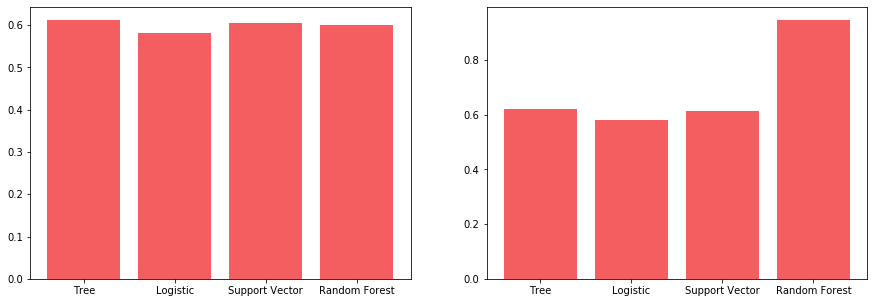

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].bar(labels, f1_scores, color='#f55e61')
axes[1].bar(labels, training_scores, color='#f55e61')